In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import trange

general = np.load("./general.npy")
switcher = np.load("./switcher.npy")
ev_switcher = np.load("./ev_switcher.npy")

device = "cpu"

In [39]:
# helper functions
def fitness_function(pop, targ):
    return (1 - torch.abs(pop.squeeze(1) - targ)).sum(axis=1) / pop.size()[
        -1
    ]  # the smaller the difference, the higher the fitness


def get_phenotypes(pop, num_indv):
    state = torch.zeros(num_indv, 1, grn_size).to(device)
    state[:, :, 0] = 1.0  # create input to the GRNs

    # keeping track of the last state
    state_before = torch.zeros(num_indv, 1, grn_size).to(device)
    for l in range(max_iter):
        state = torch.matmul(state, pop)  # each matrix in the population is multiplied
        state = state * alpha
        state = torch.sigmoid(state)
        diffs = torch.abs(state_before - state).sum(axis=(1, 2))
        which_repeat = torch.where(diffs == 0)
        state_before = state

    return state


ones = torch.ones(1, int(50 / 2)).to(device)
zeros = torch.zeros(1, int(50 / 2)).to(device)
targA = torch.cat((ones, zeros), 1)
targB = torch.cat((zeros, ones), 1)
targs = [targA, targB]

grn_size = 50
alpha = 10
mut_rate = 0.1
mut_size = 0.5
max_iter = 100


# the real deal
def switcher_coeff(grn):
    num_clones = 50
    num_genes_fit = 50

    grn = torch.Tensor(grn)

    clones = grn.to(device).repeat([num_clones, 1, 1])  # create copies of parents

    # Mutate clones
    num_genes_mutate = int(grn_size * grn_size * len(clones) * mut_rate)
    mylist = torch.zeros(grn_size * grn_size * len(clones), device=device)
    mylist[:num_genes_mutate] = 1
    shuffled_idx = torch.randperm(grn_size * grn_size * len(clones), device=device)
    mask = mylist[shuffled_idx].reshape(
        len(clones), grn_size, grn_size
    )  # select genes to mutate
    clones = (
        clones
        + (clones * mask) * torch.randn(size=clones.shape, device=device) * mut_size
    )  # mutate only children only at certain genes

    # Get clone phenotypes
    clone_states = get_phenotypes(clones, num_clones)
    clone_phenos = clone_states[:, :, :num_genes_fit]

    # Get fitness
    fits = fitness_function(clone_phenos, targA)
    #one = 1 - abs(len(fits[torch.where(fits > 0.8)]) / num_clones - 0.5)
    #other = 1 - abs(len(fits[torch.where(fits < 0.2)]) / num_clones - 0.5)

    return fits.std().item() * 2
    # return (one + other) / 2
    
def specialist_coeff(grn):
    num_clones = 50
    num_genes_fit = 50

    grn = torch.Tensor(grn)

    clones = grn.to(device).repeat([num_clones, 1, 1])  # create copies of parents

    # Mutate clones
    num_genes_mutate = int(grn_size * grn_size * len(clones) * mut_rate)
    mylist = torch.zeros(grn_size * grn_size * len(clones), device=device)
    mylist[:num_genes_mutate] = 1
    shuffled_idx = torch.randperm(grn_size * grn_size * len(clones), device=device)
    mask = mylist[shuffled_idx].reshape(
        len(clones), grn_size, grn_size
    )  # select genes to mutate
    clones = (
        clones
        + (clones * mask) * torch.randn(size=clones.shape, device=device) * mut_size
    )  # mutate only children only at certain genes

    # Get clone phenotypes
    clone_states = get_phenotypes(clones, num_clones)
    clone_phenos = clone_states[:, :, :num_genes_fit]

    # Get fitness
    fits = fitness_function(clone_phenos, targA).mean().item()
    fits2 = 1-fits
    
    #one = 1 - abs(len(fits[torch.where(fits > 0.8)]) / num_clones - 0.5)
    #other = 1 - abs(len(fits[torch.where(fits < 0.2)]) / num_clones - 0.5)

    return (max(fits,fits2) - 0.5)*2
    # return (one + other) / 2


def generalist_coeff(grn):
    grn = torch.Tensor(grn)

    pheno = get_phenotypes(grn, 1)
    fitness = (0.5 - (abs(pheno - 0.5).mean())) * 4

    return np.clip(fitness.item(), 0, 1)


def mutate_grn(grn, mut_rate):
    grn = torch.Tensor(grn)

    num_genes_mutate = int(grn_size * grn_size * 1 * mut_rate)
    mylist = torch.zeros(grn_size * grn_size * 1, device=device)
    mylist[:num_genes_mutate] = 1
    shuffled_idx = torch.randperm(grn_size * grn_size * 1, device=device)
    mask = mylist[shuffled_idx].reshape(1, grn_size, grn_size)  # select genes to mutate
    grn = grn + (grn * mask) * torch.randn(size=grn.shape, device=device) * mut_size
    # mutate only children only at certain genes

    grn = torch.flatten(grn, start_dim=0, end_dim=1)

    return grn.detach().cpu().numpy()


def unzip(l):
    return list(zip(*l))


def trajectory(ancestor, steps=20):
    grn = np.copy(ancestor)
    coeffs = []
    for i in trange(steps):
        x, y = generalist_coeff(grn), switcher_coeff(grn)
        grn = mutate_grn(grn, mut_rate=0.4)
        coeffs.append((x, y))
    return coeffs

def trajectory_2(ancestor, steps=20):
    grn = np.copy(ancestor)
    coeffs = []
    for i in trange(steps):
        x, y = specialist_coeff(grn), switcher_coeff(grn)
        grn = mutate_grn(grn, mut_rate=0.4)
        coeffs.append((x, y))
    return coeffs

def trajectory_3(ancestor, steps=20):
    grn = np.copy(ancestor)
    coeffs = []
    for i in trange(steps):
        x, y = generalist_coeff(grn), specialist_coeff(grn)
        grn = mutate_grn(grn, mut_rate=0.4)
        coeffs.append((x, y))
    return coeffs



100%|█████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 21.93it/s]


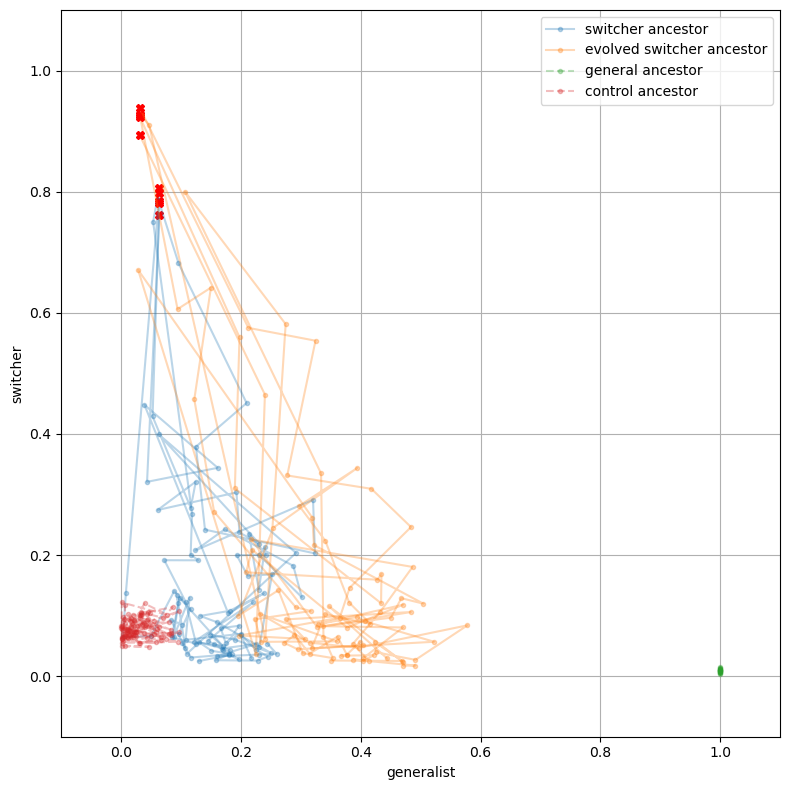

In [36]:
general_coeffs = trajectory(general)

ALPHA = 0.3
REPS = 5

plt.figure(figsize=(8, 8))
for i in range(REPS):
    switcher_coeffs = trajectory(switcher)
    xs, ys = unzip(switcher_coeffs)
    if i == 0:
        plt.plot(xs, ys, ".-", color="C0", label="switcher ancestor", alpha=ALPHA)
        plt.plot(xs[0], ys[0], "X", color="red")
    else:
        plt.plot(xs, ys, ".-", color="C0", alpha=ALPHA)
        plt.plot(xs[0], ys[0], "X", color="red")
        
for i in range(REPS):
    switcher_coeffs = trajectory(ev_switcher)
    xs, ys = unzip(switcher_coeffs)
    if i == 0:
        plt.plot(xs, ys, ".-", color="C1", label="evolved switcher ancestor", alpha=ALPHA)
        plt.plot(xs[0], ys[0], "X", color="red")
    else:
        plt.plot(xs, ys, ".-", color="C1", alpha=ALPHA)
        plt.plot(xs[0], ys[0], "X", color="red")

xs, ys = unzip(general_coeffs)
plt.plot(xs, ys, ".--", color="C2", label="general ancestor", alpha=ALPHA)

for i in range(REPS):
    control = np.random.randn(grn_size, grn_size)
    control_coeffs = trajectory(control)
    xs, ys = unzip(control_coeffs)
    if i == 0:
        plt.plot(xs, ys, ".--", color="C3", label="control ancestor", alpha=ALPHA)
    else:
        plt.plot(xs, ys, ".--", color="C3", alpha=ALPHA)

plt.xlim(-0.1, 1.1)
plt.xlabel("generalist")
plt.ylim(-0.1, 1.1)
plt.ylabel("switcher")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.15it/s]


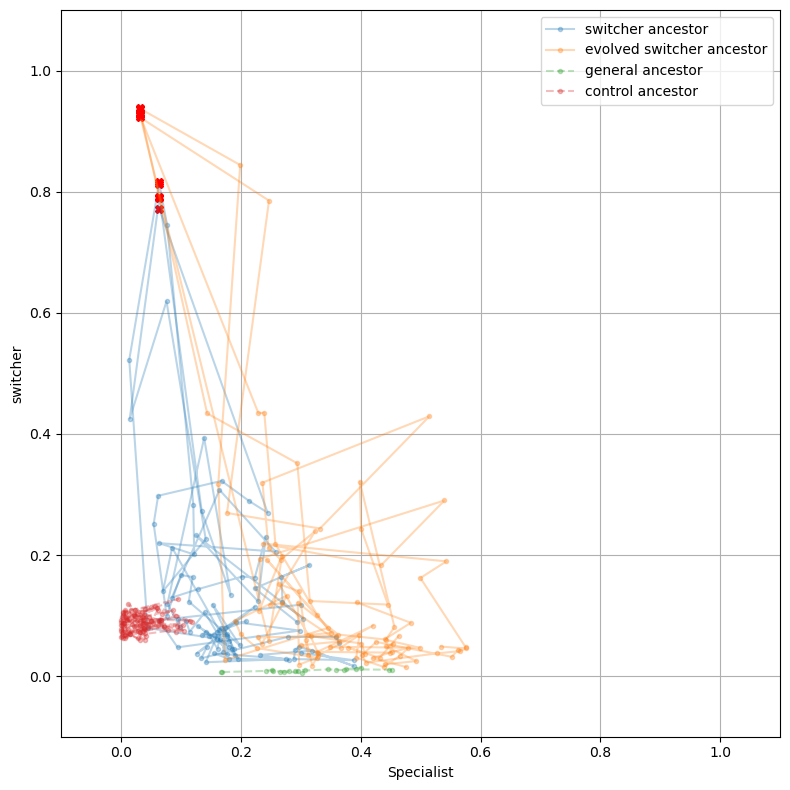

In [40]:
general_coeffs = trajectory_2(general)

ALPHA = 0.3
REPS = 5

plt.figure(figsize=(8, 8))
for i in range(REPS):
    switcher_coeffs = trajectory(switcher)
    xs, ys = unzip(switcher_coeffs)
    if i == 0:
        plt.plot(xs, ys, ".-", color="C0", label="switcher ancestor", alpha=ALPHA)
        plt.plot(xs[0], ys[0], "X", color="red")
    else:
        plt.plot(xs, ys, ".-", color="C0", alpha=ALPHA)
        plt.plot(xs[0], ys[0], "X", color="red")
        
for i in range(REPS):
    switcher_coeffs = trajectory(ev_switcher)
    xs, ys = unzip(switcher_coeffs)
    if i == 0:
        plt.plot(xs, ys, ".-", color="C1", label="evolved switcher ancestor", alpha=ALPHA)
        plt.plot(xs[0], ys[0], "X", color="red")
    else:
        plt.plot(xs, ys, ".-", color="C1", alpha=ALPHA)
        plt.plot(xs[0], ys[0], "X", color="red")

xs, ys = unzip(general_coeffs)
plt.plot(xs, ys, ".--", color="C2", label="general ancestor", alpha=ALPHA)

for i in range(REPS):
    control = np.random.randn(grn_size, grn_size)
    control_coeffs = trajectory(control)
    xs, ys = unzip(control_coeffs)
    if i == 0:
        plt.plot(xs, ys, ".--", color="C3", label="control ancestor", alpha=ALPHA)
    else:
        plt.plot(xs, ys, ".--", color="C3", alpha=ALPHA)

plt.xlim(-0.1, 1.1)
plt.xlabel("Specialist")
plt.ylim(-0.1, 1.1)
plt.ylabel("switcher")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.17it/s]


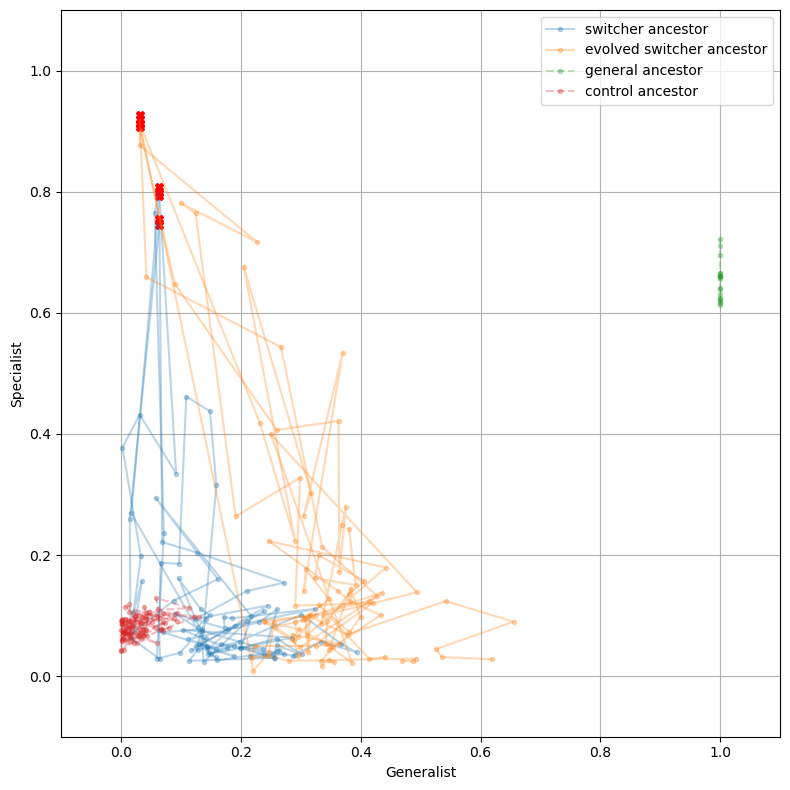

In [38]:
general_coeffs = trajectory_3(general)

ALPHA = 0.3
REPS = 5

plt.figure(figsize=(8, 8))
for i in range(REPS):
    switcher_coeffs = trajectory(switcher)
    xs, ys = unzip(switcher_coeffs)
    if i == 0:
        plt.plot(xs, ys, ".-", color="C0", label="switcher ancestor", alpha=ALPHA)
        plt.plot(xs[0], ys[0], "X", color="red")
    else:
        plt.plot(xs, ys, ".-", color="C0", alpha=ALPHA)
        plt.plot(xs[0], ys[0], "X", color="red")
        
for i in range(REPS):
    switcher_coeffs = trajectory(ev_switcher)
    xs, ys = unzip(switcher_coeffs)
    if i == 0:
        plt.plot(xs, ys, ".-", color="C1", label="evolved switcher ancestor", alpha=ALPHA)
        plt.plot(xs[0], ys[0], "X", color="red")
    else:
        plt.plot(xs, ys, ".-", color="C1", alpha=ALPHA)
        plt.plot(xs[0], ys[0], "X", color="red")

xs, ys = unzip(general_coeffs)
plt.plot(xs, ys, ".--", color="C2", label="general ancestor", alpha=ALPHA)

for i in range(REPS):
    control = np.random.randn(grn_size, grn_size)
    control_coeffs = trajectory(control)
    xs, ys = unzip(control_coeffs)
    if i == 0:
        plt.plot(xs, ys, ".--", color="C3", label="control ancestor", alpha=ALPHA)
    else:
        plt.plot(xs, ys, ".--", color="C3", alpha=ALPHA)

plt.xlim(-0.1, 1.1)
plt.xlabel("Generalist")
plt.ylim(-0.1, 1.1)
plt.ylabel("Specialist")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()